<a href="https://colab.research.google.com/github/anonymouaccount/From-Theory-to-Evaluation-An-Experimental-Survey-on-Explainable-Artificial-Intelligence/blob/main/Image_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image **Data**

In [ ]:
from google.colab import userdata

# **CradCAM**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 3.2756
Epoch 2/10, Loss: 0.7012
Epoch 3/10, Loss: 0.6750
Epoch 4/10, Loss: 0.6755
Epoch 5/10, Loss: 0.6548
Epoch 6/10, Loss: 0.6049
Epoch 7/10, Loss: 0.6239
Epoch 8/10, Loss: 0.5627
Epoch 9/10, Loss: 0.5340
Epoch 10/10, Loss: 0.5288
Accuracy of the model on the test images: 67.14%


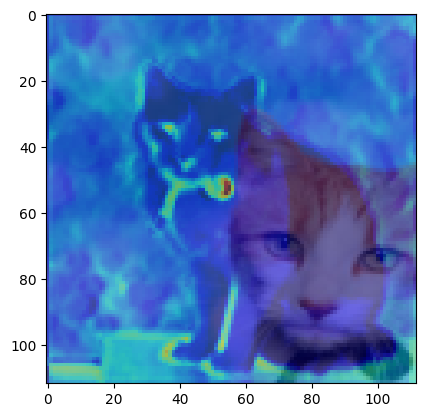

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically calculate the size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def hook_fn(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(hook_fn)

    def generate_cam(self, input_image, target_class):
        input_image = input_image.to(device)  # Ensure input is on the correct device
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)  # Move heatmap to CPU for visualization
        heatmap /= np.max(heatmap)
        return heatmap

# Apply Grad-CAM
target_layer = model.conv2  # Choose the target layer for Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Visualize Grad-CAM
def visualize_gradcam(image, heatmap):
    image = image.cpu().squeeze().permute(1, 2, 0)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

# Test Grad-CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = grad_cam.generate_cam(sample_image, sample_label[0].item())
visualize_gradcam(sample_image.squeeze(), heatmap)

In [ ]:
import torch
import numpy as np
from torchvision.transforms.functional import resize

# Fidelity Score
def fidelity_score(model, image, heatmap, target_class, threshold=0.5):
    """
    Compute fidelity score for a given image and its Grad-CAM heatmap.
    """
    # Resize the heatmap to match the input image dimensions
    heatmap = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    heatmap = resize(heatmap, (image.size(2), image.size(3)))  # Resize to match image dimensions
    heatmap = heatmap.squeeze().to(device)  # Remove batch and channel dimensions, move to device

    # Create a binary mask from the heatmap
    mask = (heatmap > threshold).float()  # Convert to binary mask

    # Mask out the non-important regions in the image
    masked_image = image.clone()
    masked_image = masked_image * mask  # Element-wise multiplication

    # Get model predictions for original and masked images
    original_output = model(image)
    masked_output = model(masked_image)

    # Check if the predictions match
    original_pred = torch.argmax(original_output, dim=1).item()
    masked_pred = torch.argmax(masked_output, dim=1).item()

    return int(original_pred == masked_pred)


# Sparsity Score
def sparsity_score(heatmap, threshold=0.5):
    """
    Compute sparsity score for a given Grad-CAM heatmap.
    """
    important_pixels = (heatmap > threshold).sum()
    total_pixels = heatmap.size
    return 1 - (important_pixels / total_pixels)


# Stability Score
def stability_score(grad_cam, image, target_class, noise_std=0.01):
    """
    Compute stability score for a given image and its Grad-CAM heatmap.
    """
    # Add small noise to the image
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    # Generate heatmaps for original and perturbed images
    original_heatmap = grad_cam.generate_cam(image, target_class)
    perturbed_heatmap = grad_cam.generate_cam(perturbed_image, target_class)

    # Compute stability score
    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    norm = np.linalg.norm(original_heatmap)
    return 1 - (diff / norm)


# Robustness Score
def robustness_score(grad_cam, image, target_class, noise_std=0.1):
    """
    Compute robustness score for a given image and its Grad-CAM heatmap.
    The score is normalized to be between 0 and 1.
    """
    # Add significant noise to the image
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    # Generate heatmaps for original and perturbed images
    original_heatmap = grad_cam.generate_cam(image, target_class)
    perturbed_heatmap = grad_cam.generate_cam(perturbed_image, target_class)

    # Compute the difference between heatmaps
    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)

    # Normalize the robustness score to be between 0 and 1
    robustness = 1 / (1 + diff)  # Inverse of the difference, scaled to [0, 1]
    return robustness


# Test Grad-CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = grad_cam.generate_cam(sample_image, sample_label[0].item())

# Compute evaluation scores
fidelity = fidelity_score(model, sample_image, heatmap, sample_label[0].item())
sparsity = sparsity_score(heatmap)
stability = stability_score(grad_cam, sample_image, sample_label[0].item())
robustness = robustness_score(grad_cam, sample_image, sample_label[0].item())

print(f"Fidelity: {fidelity}")
print(f"Sparsity: {sparsity:.4f}")
print(f"Stability: {stability:.4f}")
print(f"Robustness: {robustness:.4f}")



Fidelity: 1
Sparsity: 0.9905
Stability: 0.9647
Robustness: 0.2161


# **CAM**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 4.6574
Epoch 2/10, Loss: 0.6910
Epoch 3/10, Loss: 0.6889
Epoch 4/10, Loss: 0.6854
Epoch 5/10, Loss: 0.6887
Epoch 6/10, Loss: 0.6706
Epoch 7/10, Loss: 0.6401
Epoch 8/10, Loss: 0.6419
Epoch 9/10, Loss: 0.6212
Epoch 10/10, Loss: 0.5979
Accuracy of the model on the test images: 57.14%


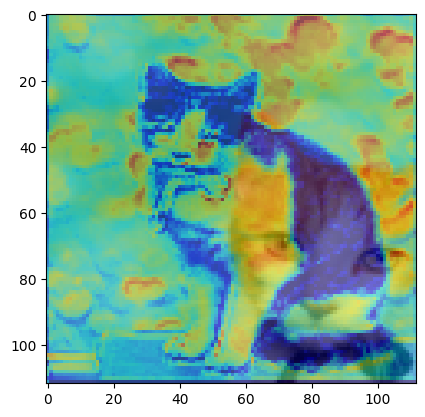

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Dynamically calculate the size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# CAM implementation
class CAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.hook_layer()

    def hook_layer(self):
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)

    def generate_cam(self, input_image, target_class):
        input_image = input_image.to(device)
        model_output = self.model(input_image)

        # Get weights from the final FC layer
        weights = self.model.fc2.weight[target_class].detach()  # Shape: (512,)

        # Ensure activations are properly reduced
        activations = self.activations.squeeze(0)  # Shape: (64, height, width)

        # Resize weights to match activation channels
        weights = weights[:activations.shape[0]]

        # Perform weighted sum across channels
        cam = torch.einsum("c,chw->hw", weights, activations)

        # Apply ReLU and normalize
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)  # Avoid division by zero

        return cam.detach().cpu().numpy()

# Apply CAM
target_layer = model.conv2  # Choose the target layer for CAM
cam = CAM(model, target_layer)

# Visualize CAM
def visualize_cam(image, heatmap):
    image = image.cpu().squeeze().permute(1, 2, 0)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

# Test CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)
heatmap = cam.generate_cam(sample_image, sample_label[0].item())
visualize_cam(sample_image.squeeze(), heatmap)


In [ ]:
import torch
import numpy as np
from torchvision.transforms.functional import resize

# Fidelity Score
def fidelity_score(model, image, heatmap, target_class, threshold=0.5):
    """
    Compute fidelity score for a given image and its CAM heatmap.
    """
    heatmap = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    heatmap = resize(heatmap, (image.size(2), image.size(3)))  # Resize to match image dimensions
    heatmap = heatmap.squeeze().to(device)  # Remove batch and channel dimensions, move to device

    # Create a binary mask from the heatmap
    mask = (heatmap > threshold).float()  # Convert to binary mask

    # Mask out the non-important regions in the image
    masked_image = image.clone()
    masked_image = masked_image * mask  # Element-wise multiplication

    # Get model predictions for original and masked images
    original_output = model(image)
    masked_output = model(masked_image)

    # Check if the predictions match
    original_pred = torch.argmax(original_output, dim=1).item()
    masked_pred = torch.argmax(masked_output, dim=1).item()

    return int(original_pred == masked_pred)

# Sparsity Score
def sparsity_score(heatmap, threshold=0.5):
    """
    Compute sparsity score for a given CAM heatmap.
    """
    important_pixels = (heatmap > threshold).sum()
    total_pixels = heatmap.size
    return 1 - (important_pixels / total_pixels)

# Stability Score
def stability_score(cam, image, target_class, noise_std=0.01):
    """
    Compute stability score for a given image and its CAM heatmap.
    """
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    original_heatmap = cam.generate_cam(image, target_class)
    perturbed_heatmap = cam.generate_cam(perturbed_image, target_class)

    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    norm = np.linalg.norm(original_heatmap)
    return 1 - (diff / norm)

# Robustness Score
def robustness_score(cam, image, target_class, noise_std=0.1):
    """
    Compute robustness score for a given image and its CAM heatmap.
    The score is normalized to be between 0 and 1.
    """
    noise = torch.randn_like(image) * noise_std
    perturbed_image = image + noise

    original_heatmap = cam.generate_cam(image, target_class)
    perturbed_heatmap = cam.generate_cam(perturbed_image, target_class)

    diff = np.linalg.norm(original_heatmap - perturbed_heatmap)
    robustness = 1 / (1 + diff)  # Inverse of the difference, scaled to [0, 1]
    return robustness

# Test CAM on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0).to(device)  # Move sample image to the correct device
heatmap = cam.generate_cam(sample_image, sample_label[0].item())

# Compute evaluation scores
fidelity = fidelity_score(model, sample_image, heatmap, sample_label[0].item())
sparsity = sparsity_score(heatmap)
stability = stability_score(cam, sample_image, sample_label[0].item())
robustness = robustness_score(cam, sample_image, sample_label[0].item())

print(f"Fidelity: {fidelity}")
print(f"Sparsity: {sparsity:.4f}")
print(f"Stability: {stability:.4f}")
print(f"Robustness: {robustness:.4f}")


Fidelity: 0
Sparsity: 0.5883
Stability: 0.9912
Robustness: 0.2017


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# **LIME**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 4.6777
Epoch 2/10, Loss: 0.6917
Epoch 3/10, Loss: 0.6920
Epoch 4/10, Loss: 0.6901
Epoch 5/10, Loss: 0.6843
Epoch 6/10, Loss: 0.6719
Epoch 7/10, Loss: 0.6852
Epoch 8/10, Loss: 0.6816
Epoch 9/10, Loss: 0.6673
Epoch 10/10, Loss: 0.6172
Accuracy of the model on the test images: 60.00%


  0%|          | 0/1000 [00:00<?, ?it/s]

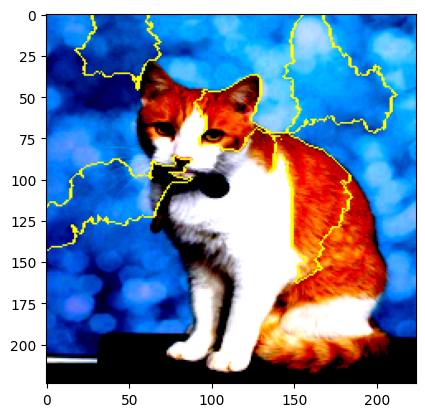

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
from torch.autograd import Variable
import zipfile
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# LIME explanation
explainer = LimeImageExplainer()

def lime_explain(model, image):
    """Explain a single image using LIME."""
    def batch_predict(images):
        images = torch.tensor(images.transpose((0, 3, 1, 2)), dtype=torch.float32).to(device)
        outputs = model(images)
        return softmax(outputs, dim=1).detach().cpu().numpy()

    # Move image to CPU before converting to NumPy
    image_cpu = image.cpu().permute(1, 2, 0).numpy()

    explanation = explainer.explain_instance(
        image_cpu,
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )
    return explanation

# Test LIME on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image = sample_image[0].to(device)

explanation = lime_explain(model, sample_image)

# Visualize LIME
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.show()


In [ ]:
# XAI Evaluation Metrics
def fidelity_score(model, instance, explanation):
    top_label = explanation.top_labels[0]  # Get the top predicted label from LIME
    mask = explanation.get_image_and_mask(top_label)[1]  # Extract mask
    masked_instance = instance.clone()
    masked_instance[:, mask == 0] = 0  # Mask out non-important regions
    original_pred = model(instance.unsqueeze(0)).argmax(dim=1).item()
    masked_pred = model(masked_instance.unsqueeze(0)).argmax(dim=1).item()
    return int(original_pred == masked_pred)

def sparsity_score(explanation):
    top_label = explanation.top_labels[0]
    mask = explanation.local_exp[top_label]  # Extract the explanation mask
    important_features = np.array([x[0] for x in mask])  # Extract feature indices
    total_features = np.prod(explanation.segments.shape)  # Total number of pixels
    return 1.0 - (len(important_features) / total_features)

def stability_score(model, instance, explanation, noise_std=0.01):
    noise = torch.randn_like(instance) * noise_std
    perturbed_instance = instance + noise
    original_exp = lime_explain(model, instance)
    perturbed_exp = lime_explain(model, perturbed_instance)
    return 1 - (np.linalg.norm(original_exp.get_image_and_mask(original_exp.top_labels[0])[1] -
                               perturbed_exp.get_image_and_mask(perturbed_exp.top_labels[0])[1]) /
                np.linalg.norm(original_exp.get_image_and_mask(original_exp.top_labels[0])[1]))

def robustness_score(model, instance, noise_std=0.1):
    noise = torch.randn_like(instance) * noise_std
    perturbed_instance = instance + noise
    original_pred = model(instance.unsqueeze(0)).argmax(dim=1).item()
    perturbed_pred = model(perturbed_instance.unsqueeze(0)).argmax(dim=1).item()
    return int(original_pred == perturbed_pred)

# Evaluate model on XAI metrics
fidelity = fidelity_score(model, sample_image, explanation)
sparsity = sparsity_score(explanation)
stability = stability_score(model, sample_image, explanation)
robustness = robustness_score(model, sample_image)

print(f'Fidelity: {fidelity}')
print(f'Sparsity: {sparsity:.4f}')
print(f'Stability: {stability:.4f}')
print(f'Robustness: {robustness:.4f}')


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fidelity: 0
Sparsity: 0.9992
Stability: 0.2841
Robustness: 1.0000


# **SHAP**

In [ ]:
!pip install shap

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Loss: 5.5287
Epoch 2/10, Loss: 0.6854
Epoch 3/10, Loss: 0.6725
Epoch 4/10, Loss: 0.6761
Epoch 5/10, Loss: 0.6655
Epoch 6/10, Loss: 0.6549
Epoch 7/10, Loss: 0.6462
Epoch 8/10, Loss: 0.6484
Epoch 9/10, Loss: 0.6240
Epoch 10/10, Loss: 0.6140
Accuracy of the model on the test images: 59.29%


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.48s/it]               


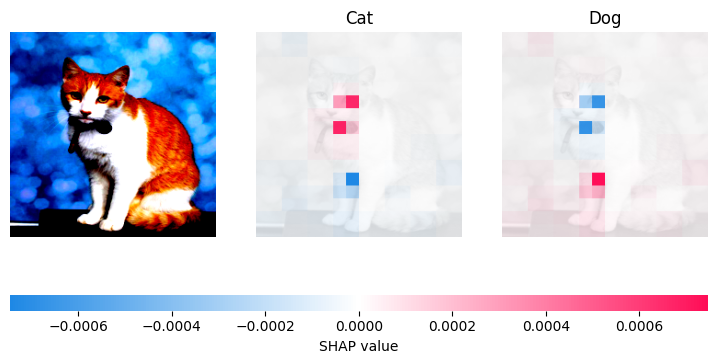

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.utils import make_grid
from torch.nn.functional import softmax
import zipfile
import shap

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/CatsDogs.zip'  # Path to the zip file
extract_to = '/content/CatsDogs'  # Directory to extract the zip file
data_dir = extract_to  # Update data_dir to the extracted directory

# Extract the zip file
def unzip_data(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip the dataset
unzip_data(zip_path, extract_to)

# Define paths for train and test directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),     # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Fixed size for 224x224 input
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cats and dogs
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# SHAP explanation
model.eval()  # Set the model to evaluation mode

# Define a SHAP explainer with proper masking
def shap_explain(model, image, background_data):
    """Explain a single image using SHAP."""

    def model_predict(images):
        # Ensure correct shape [batch, channels, height, width]
        images = torch.tensor(images.transpose((0, 3, 1, 2)), dtype=torch.float32).to(device)
        with torch.no_grad():
            outputs = model(images)
        return softmax(outputs, dim=1).cpu().numpy()

    # Convert background data to NumPy in proper shape
    background_cpu = background_data.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to [batch, height, width, channels]

    # Initialize SHAP explainer with Image masker
    masker = shap.maskers.Image("inpaint_telea", background_cpu[0].shape)
    explainer = shap.Explainer(model_predict, masker, output_names=["Cat", "Dog"])

    # Convert the single image to NumPy format in proper shape
    image_cpu = image.cpu().unsqueeze(0).numpy().transpose((0, 2, 3, 1))  # Convert to [batch, height, width, channels]

    # Compute SHAP values
    shap_values = explainer(image_cpu)

    return shap_values

# Select a small batch of background images for SHAP
background_data, _ = next(iter(test_loader))
background_data = background_data[:10].to(device)  # Take 10 images as background

# Select a sample image for explanation
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0].to(device)

# Generate SHAP explanation
shap_values = shap_explain(model, sample_image, background_data)

# Visualize SHAP explanation
shap.image_plot(shap_values)


In [ ]:
# Fidelity Calculation
original_prediction = model(sample_image.unsqueeze(0)).argmax().item()
perturbed_image = sample_image.clone()

# Compute SHAP importance mask correctly
shap_importance_mask = (shap_values.values[0, :, :, :, :].sum(axis=-2).sum(axis=-1) > 0)
shap_importance_mask = torch.tensor(shap_importance_mask, dtype=torch.bool)

# Apply mask correctly
for c in range(perturbed_image.shape[0]):
    perturbed_image[c, shap_importance_mask] = 0

perturbed_prediction = model(perturbed_image.unsqueeze(0)).argmax().item()
fidelity = 1 - abs(original_prediction - perturbed_prediction) / max(original_prediction, perturbed_prediction, 1)
fidelity = max(0, min(1, fidelity))
print(f"Fidelity: {fidelity:.4f}")

# Stability
perturbation = torch.randn_like(sample_image) * 0.1
perturbed_image = sample_image + perturbation
perturbed_shap_values = shap_explain(model, perturbed_image, background_data)

# Convert SHAP values to PyTorch tensors
shap_tensor = torch.tensor(shap_values.values, dtype=torch.float32)
perturbed_shap_tensor = torch.tensor(perturbed_shap_values.values, dtype=torch.float32)

stability = 1 - torch.norm(shap_tensor - perturbed_shap_tensor) / (torch.norm(shap_tensor) + 1e-8)
stability = max(0, min(1, stability))
print(f"Stability: {stability:.4f}")

# Sparsity
non_zero_shap = np.count_nonzero(shap_values.values)
total_features = np.prod(shap_values.values.shape)
sparsity = 1 - (non_zero_shap / (total_features + 1e-8))
sparsity = max(0, min(1, sparsity))
print(f"Sparsity: {sparsity:.4f}")

# Robustness
perturbation = torch.randn_like(sample_image) * 0.5
perturbed_image = sample_image + perturbation
perturbed_shap_values = shap_explain(model, perturbed_image, background_data)

# Convert perturbed SHAP values to tensor
perturbed_shap_tensor = torch.tensor(perturbed_shap_values.values, dtype=torch.float32)

robustness = torch.norm(shap_tensor) / (torch.norm(shap_tensor - perturbed_shap_tensor) + 1e-8)
robustness = max(0, min(1, robustness))
print(f"Robustness: {robustness:.4f}")


Fidelity: 0.0000


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.85s/it]               


Stability: 0.4029
Sparsity: 0.0000


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.90s/it]               

Robustness: 1.0000
